## Data understanding phase

### Collect initial data

Boilerplate code: importing modules and mounting Google Drive

In [ ]:
import pandas as pd
from sklearn import preprocessing, svm
import numpy as np
from datetime import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Mount Google Drive
drive.mount('/content/drive')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Mounted at /content/drive


Load *COMPAS* dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MachineLearning/compas-scores.csv")
# df_debug = pd.read_csv("/content/drive/MyDrive/MachineLearning/compas-scores.csv") 
df.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,num_r_cases,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.000,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.000,F,Aggravated Assault w/Firearm,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN,-1,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.000,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.000,F,Felony Battery w/Prior Convict,1,NaN,13009779CF10A,F,NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.000,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.000,F,Possession of Cocaine,1,NaN,13011511MM10A,M,0.000,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.000,F,Possession of Cannabis,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13
5,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.000,F,arrest case no charge,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,1,Low,2013-03-26,Risk of Recidivism,1,Low,2013-03-26
6,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.000,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.000,M,Battery,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,1,Low,2013-11-30,Risk of Recidivism,1,Low,2013-11-30
7,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.000,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.000,F,Possession Burglary Tools,1,NaN,14004485CF10A,F,0.000,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,2,Low,2014-02-19,Risk of Recidivism,6,Medium,2014-02-19
8,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.000,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.000,F,arrest case no charge,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,3,Low,2013-08-30,Risk of Recidivism,4,Low,2013-08-30
9,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.000,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.000,M,Battery,0,NaN,NaN,O,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Risk of Violence,1,Low,2014-03-16,Risk of Recidivism,1,Low,2014-03-16


### Data exploration (visualizzazione plot e creazione statistiche)

#### Textual information - statistics

Get general information on the dataset, such as shape

In [ ]:
df.shape

(11757, 47)

In [ ]:
df.size

552579

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

Counting label occurrences. This is to validate the need for over/undersampling in the Modeling phase

In [ ]:
df.is_recid.value_counts()

 0    7335
 1    3703
-1     719
Name: is_recid, dtype: int64

Convert features of type object to categorical, to have maximum compatibility with plotting and modeling software

In [ ]:
for attribute in df.columns:
    if df[attribute].dtype == object:
        df[attribute] = df[attribute].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       11757 non-null  int64   
 1   name                     11757 non-null  category
 2   first                    11757 non-null  category
 3   last                     11757 non-null  category
 4   compas_screening_date    11757 non-null  category
 5   sex                      11757 non-null  category
 6   dob                      11757 non-null  category
 7   age                      11757 non-null  int64   
 8   age_cat                  11757 non-null  category
 9   race                     11757 non-null  category
 10  juv_fel_count            11757 non-null  int64   
 11  decile_score             11757 non-null  int64   
 12  juv_misd_count           11757 non-null  int64   
 13  juv_other_count          11757 non-null  int64   
 14  priors

Show statistics of attributes (such as mean, std, quartiles). First numerical, then categorical

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,11757.000,5879.000,3394.098,1.000,2940.000,5879.000,8818.000,11757.000
age,11757.000,35.143,12.023,18.000,25.000,32.000,43.000,96.000
juv_fel_count,11757.000,0.062,0.445,0.000,0.000,0.000,0.000,20.000
decile_score,11757.000,4.371,2.878,-1.000,2.000,4.000,7.000,10.000
juv_misd_count,11757.000,0.076,0.450,0.000,0.000,0.000,0.000,13.000
juv_other_count,11757.000,0.094,0.472,0.000,0.000,0.000,0.000,17.000
priors_count,11757.000,3.082,4.687,0.000,0.000,1.000,4.000,43.000
days_b_screening_arrest,10577.000,-0.878,72.889,-597.000,-1.000,-1.000,-1.000,1057.000
c_days_from_compas,11015.000,63.588,341.900,0.000,1.000,1.000,2.000,9485.000
is_recid,11757.000,0.254,0.558,-1.000,0.000,0.000,1.000,1.000


In [ ]:
df.describe(include = 'category').T

,count,unique,top,freq
name,11757,11584,john brown,4
first,11757,4058,michael,264
last,11757,5921,williams,145
compas_screening_date,11757,704,2013-03-20,39
sex,11757,2,Male,9336
dob,11757,7800,1989-04-27,6
age_cat,11757,3,25 - 45,6649
race,11757,6,African-American,5813
c_jail_in,10577,10577,2013-01-01 01:31:55,1
c_jail_out,10577,10517,2014-02-12 10:41:00,4


#### Textual information - low variance columns

Analyzing in-depth the occurrences of the lowest variance columns. These are the columns where the histogram is strongly centered around the mean, with very little dispersion. They will be useful for modeling purposes.

In [ ]:
df['juv_misd_count'].value_counts(normalize=True).head(20)

0    0.953
1    0.033
2    0.009
3    0.003
4    0.001
5    0.001
6    0.000
8    0.000
12   0.000
7    0.000
13   0.000
Name: juv_misd_count, dtype: float64

In [ ]:
df['juv_fel_count'].value_counts(normalize=True)

0    0.964
1    0.024
2    0.007
3    0.003
4    0.001
5    0.001
8    0.000
6    0.000
10   0.000
9    0.000
20   0.000
13   0.000
Name: juv_fel_count, dtype: float64

In [ ]:
df['priors_count'].value_counts(normalize=True).head(20)

0    0.356
1    0.187
2    0.109
3    0.073
4    0.050
5    0.040
6    0.030
7    0.027
8    0.022
9    0.017
10   0.014
11   0.011
13   0.009
12   0.009
14   0.007
15   0.006
16   0.005
17   0.004
18   0.004
19   0.003
Name: priors_count, dtype: float64

#### Graphical information - histograms (numeric)

Below there will be histograms of the columns that we deemed more important w.r.t. the problem scope. Specifically, columns with more than 60% of null values will not be plotted.

In [ ]:
numeric_cols_vector = ['days_b_screening_arrest', 'c_days_from_compas', 
                       'v_decile_score', 'age', 'juv_fel_count', 'decile_score', 
                       'juv_misd_count', 'juv_other_count', 'priors_count', 'is_recid']
numeric_cols_df = df[numeric_cols_vector]
numeric_cols_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   days_b_screening_arrest  10577 non-null  float64
 1   c_days_from_compas       11015 non-null  float64
 2   v_decile_score           11757 non-null  int64  
 3   age                      11757 non-null  int64  
 4   juv_fel_count            11757 non-null  int64  
 5   decile_score             11757 non-null  int64  
 6   juv_misd_count           11757 non-null  int64  
 7   juv_other_count          11757 non-null  int64  
 8   priors_count             11757 non-null  int64  
 9   is_recid                 11757 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 918.6 KB


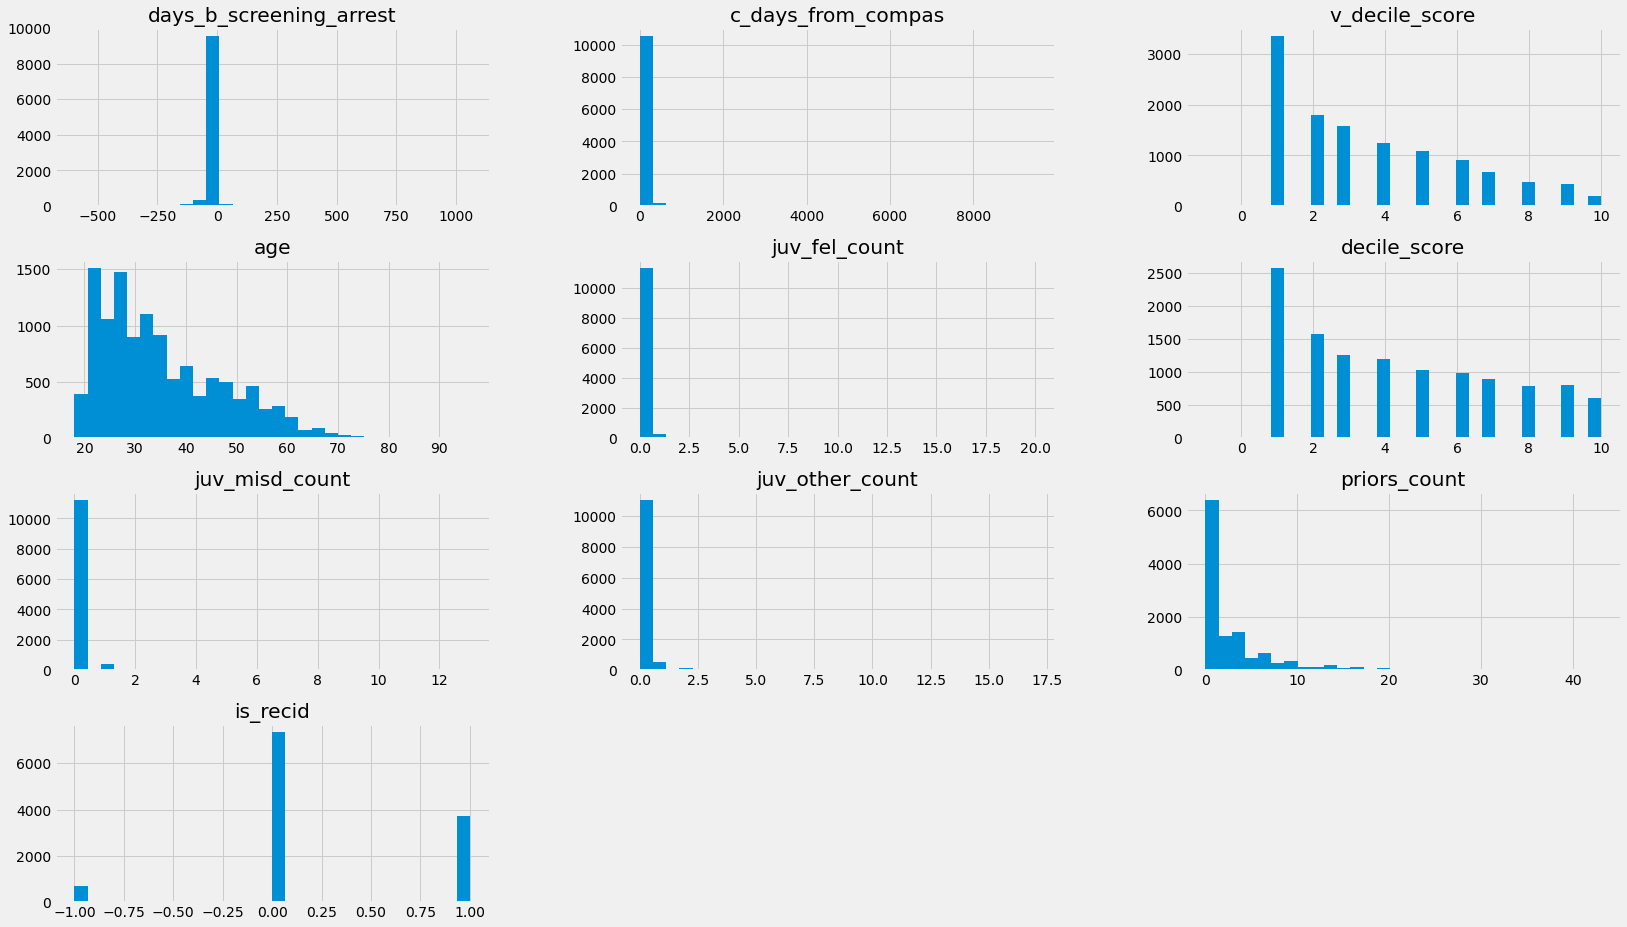

In [ ]:
plt.style.use('fivethirtyeight')
# _: trick to avoid useless text printed
_ = numeric_cols_df.hist(figsize=(25,15), bins=30)

Some distributions are skewed to the left, such as age, while many are strongly centered around one single value, such as *juv_count*.

#### Graphical information - histograms (categorical)

Isolating the most relevant categorical columns, then plotting each one. We exclude dates (separately plotted), case IDs, univariate columns.

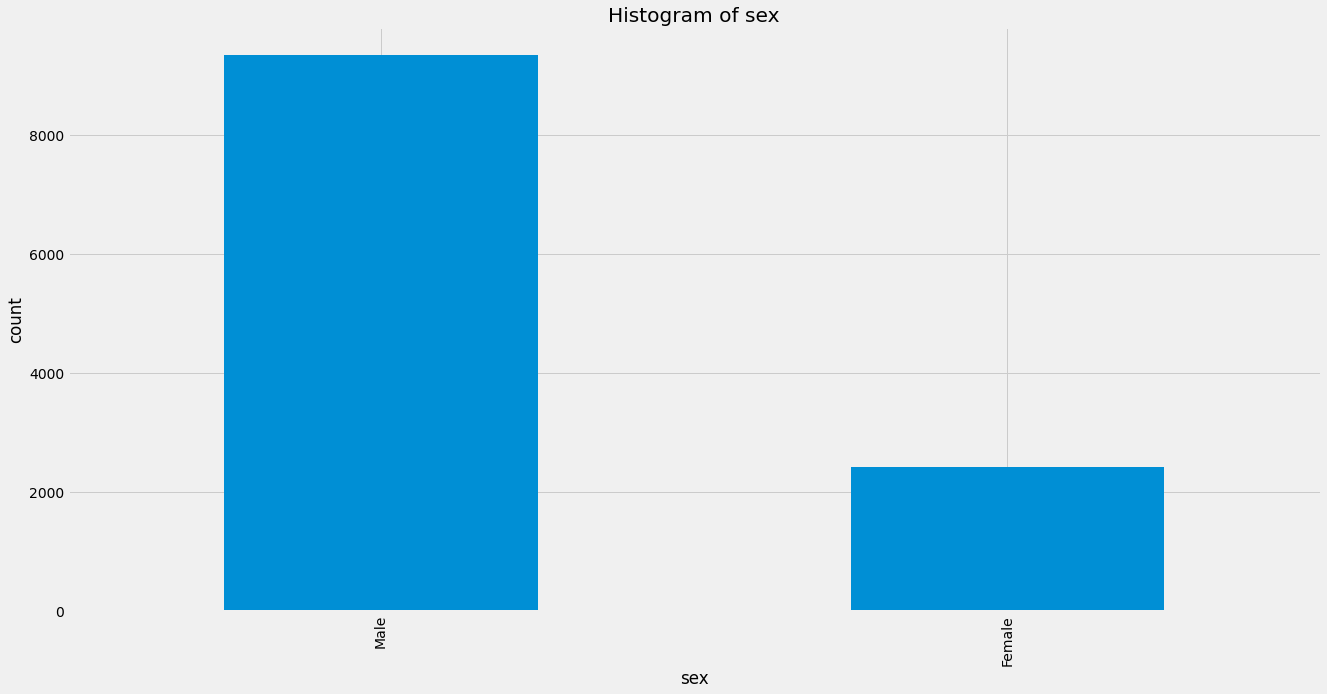

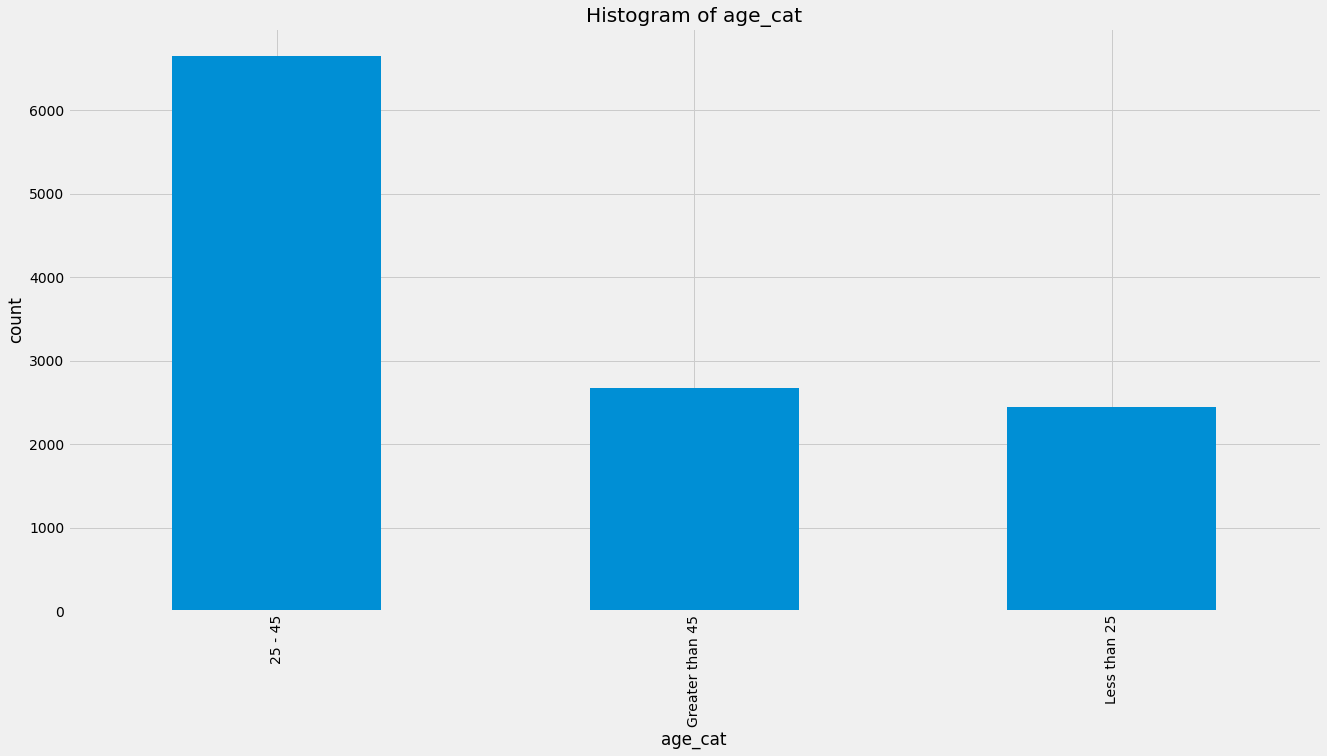

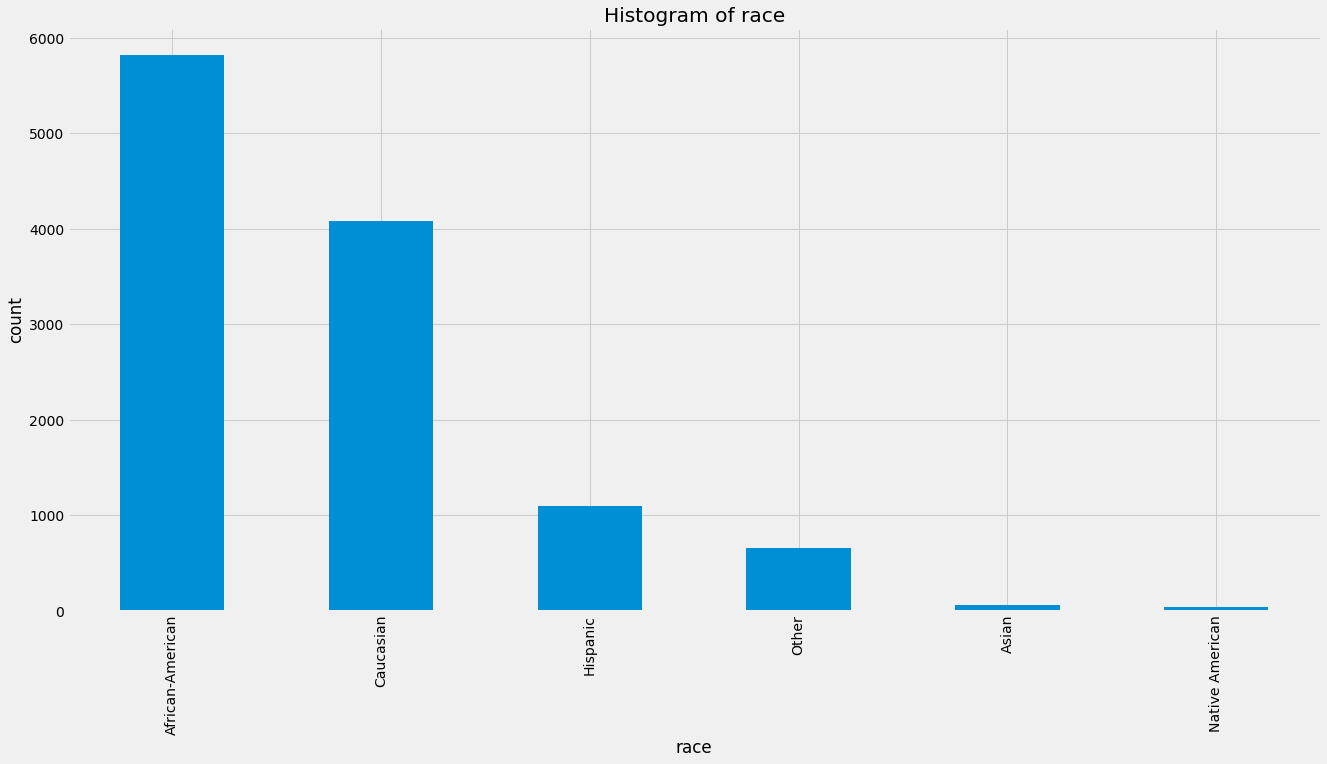

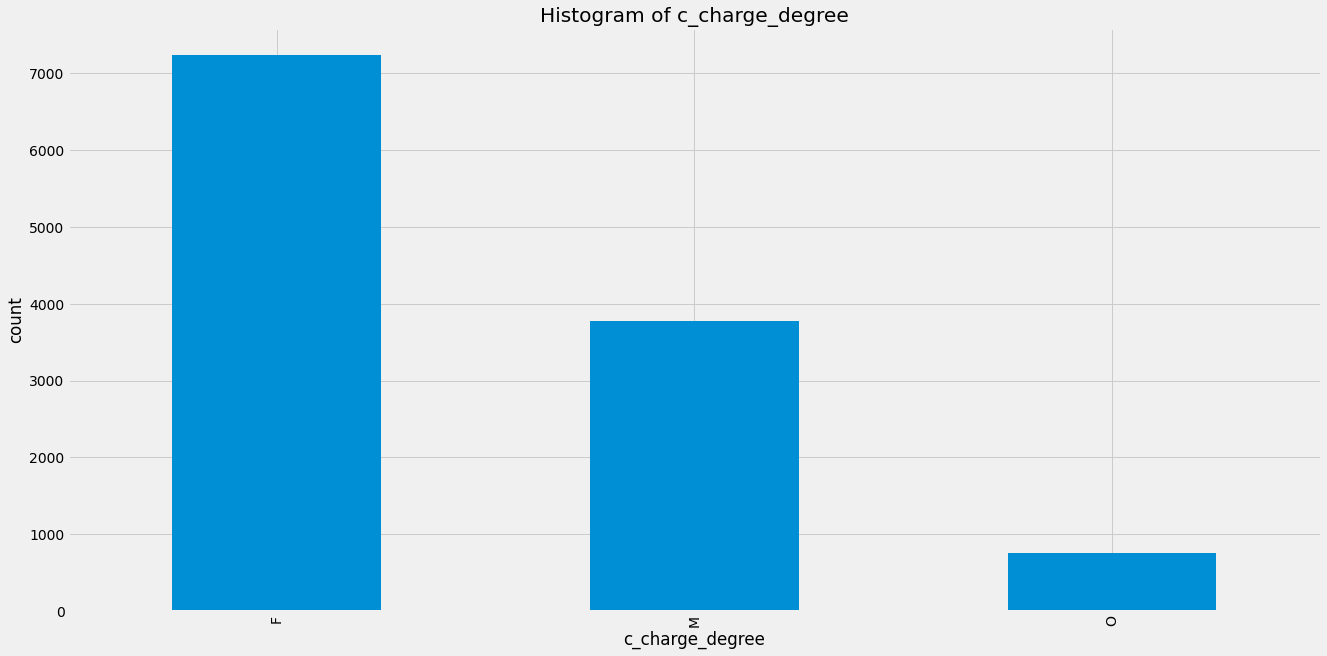

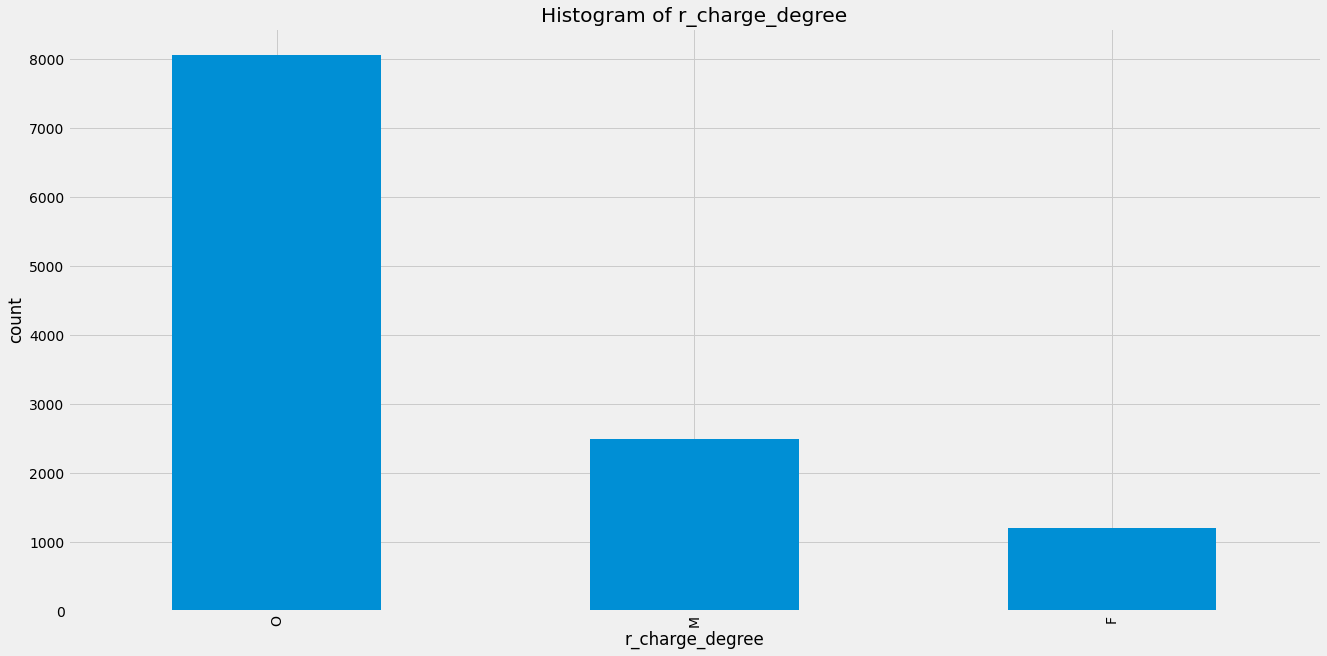

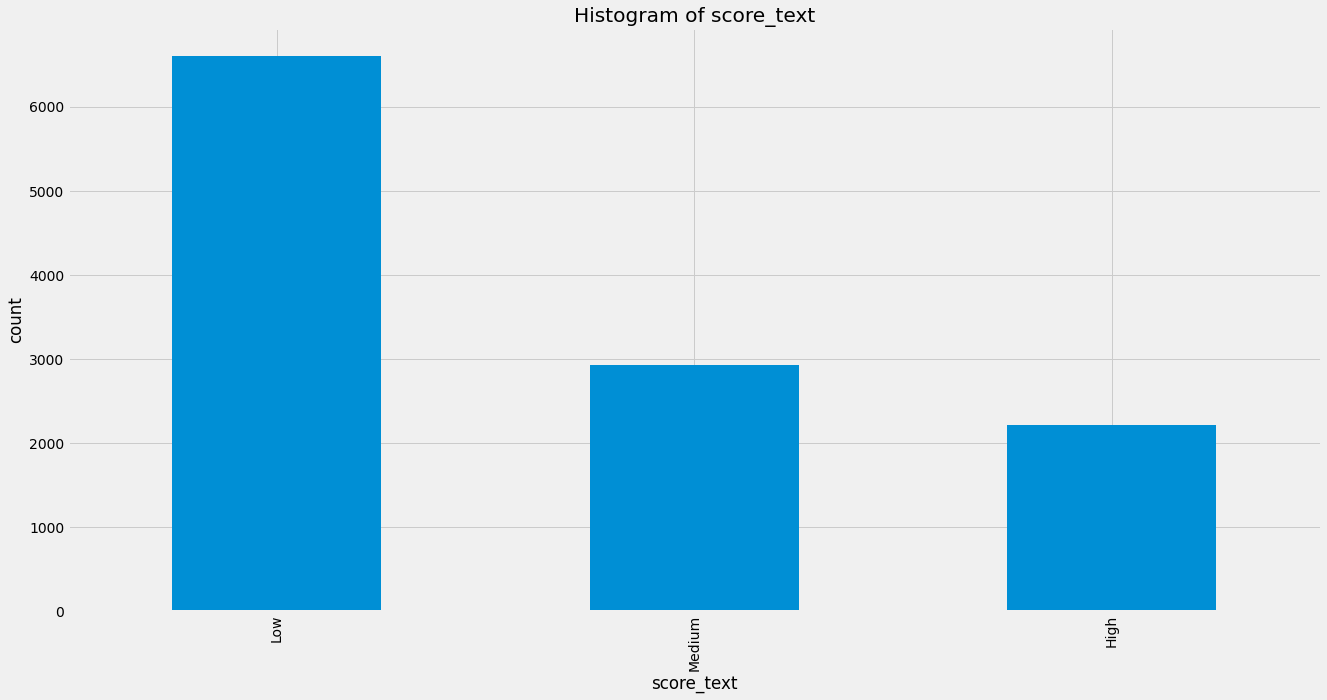

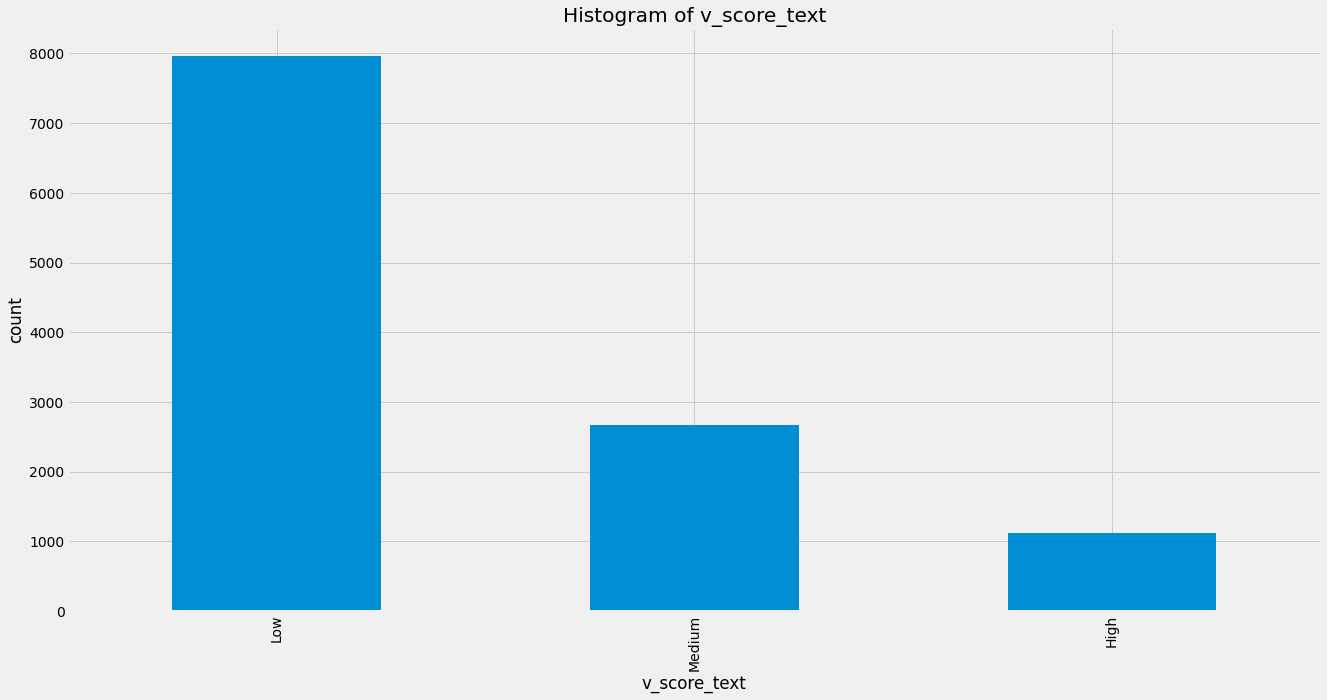

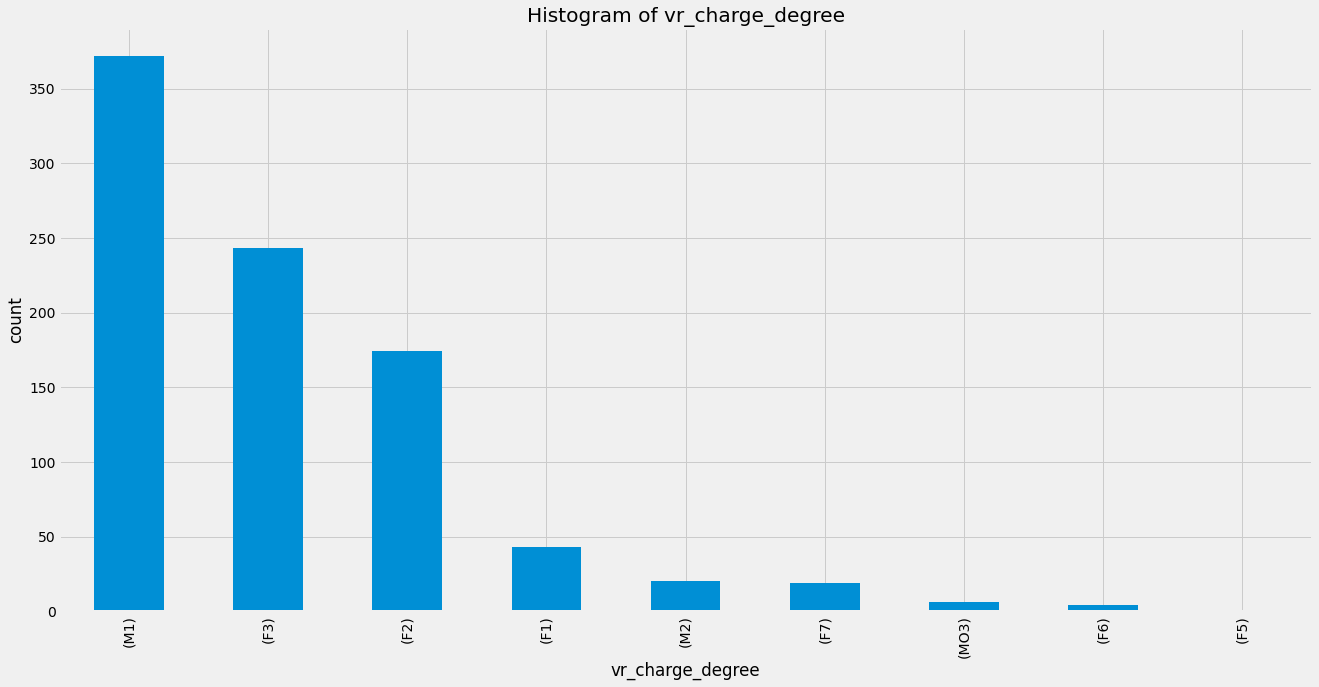

In [ ]:
categorical_to_plot = ['sex', 'age_cat', 'race', 'c_charge_degree', 
                'r_charge_degree', 'score_text', 'v_score_text',
                'vr_charge_degree']

for category in categorical_to_plot:
  counts = df[category].value_counts()
  counts.plot(kind = 'bar', figsize = (20,10)) 
  plt.ylabel('count')
  plt.xlabel(category)
  plt.title(f"Histogram of {category}")
  plt.show()

#### Graphical information - plots (dates)

Below there are some time plots of what we deemed to be some of the most significant date columns.

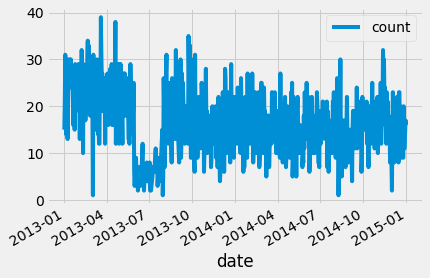

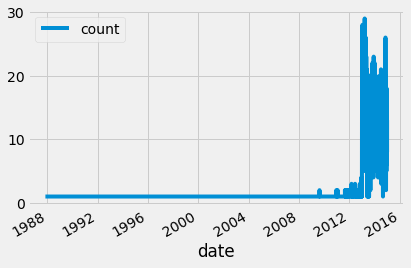

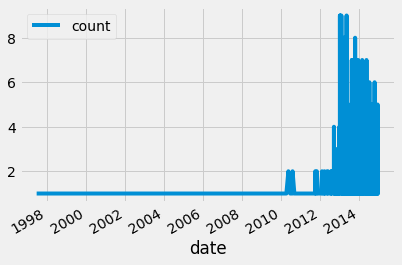

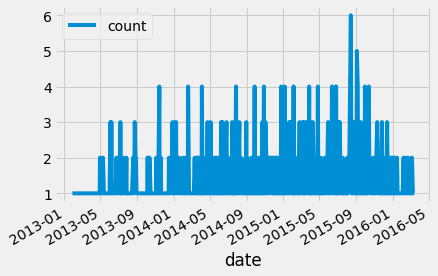

In [ ]:
col_dates_to_plot = ['compas_screening_date', 'c_offense_date', 'c_arrest_date',
                    'vr_offense_date']

for c in df.columns:
  if c in col_dates_to_plot:
    c_counts = df[c].value_counts()
    date_count_df = pd.DataFrame({'date': c_counts.index, 'count': c_counts.values})
    date_count_df['date'] = pd.to_datetime(date_count_df['date'], 
                                             format='%Y-%m-%d')
    date_count_df.set_index(['date'], inplace=True)
    date_count_df.plot()

These plots do not give any particular insights.

#### Graphical information - histograms by class label

Plotting number of priors

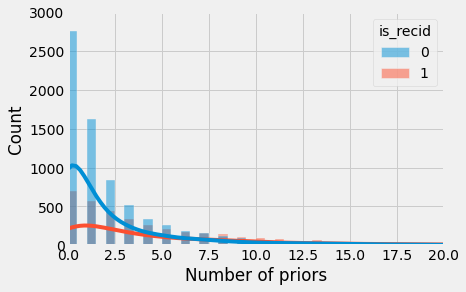

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.histplot(x=df_is_recid['priors_count'], hue='is_recid', kde=1, data=df_is_recid, binwidth=0.5)
plt.xlabel("Number of priors")
plt.xlim(0 , 20)
plt.ylim(0 , 3000)
plt.show()

Number of priors is a strongly discriminant column w.r.t. the class label.

Plotting juvenile crimes

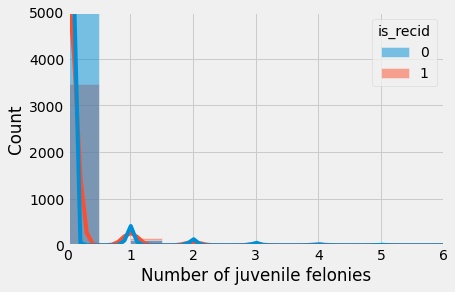

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.histplot(x=df_is_recid['juv_fel_count'], hue='is_recid', data=df_is_recid, kde=1, binwidth=0.5)
plt.xlabel("Number of juvenile felonies")
plt.xlim(0 , 6)
plt.ylim(0 , 5000)
plt.show()

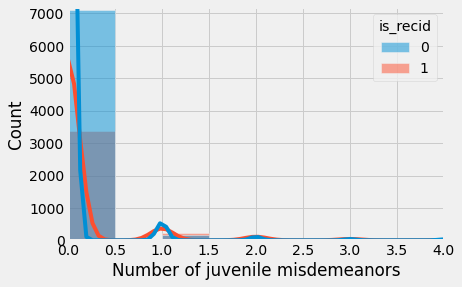

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.histplot(x=df_is_recid['juv_misd_count'], hue='is_recid', data=df_is_recid, kde=1, binwidth=0.5)
plt.xlabel("Number of juvenile misdemeanors")
plt.xlim(0 , 4)
plt.ylim(0 , 7200)
plt.show()

Juvenile felonies and misdemeanors are strongly discriminant as well.

#### Graphical information - histograms of categorical attributes w.r.t. class label


Plotting race

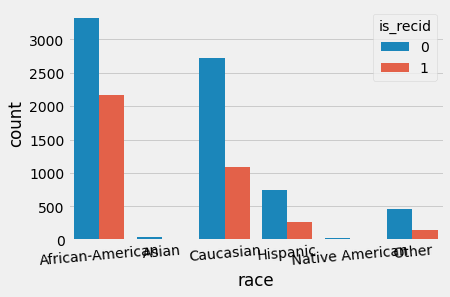

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.countplot(x=df_is_recid['race'], hue='is_recid', data=df_is_recid)
plt.xticks(rotation=5)
plt.show()

Plotting age category

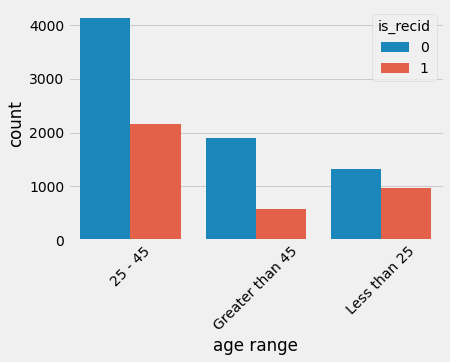

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.countplot(x=df_is_recid['age_cat'], hue='is_recid', data=df_is_recid)
plt.xlabel("age range")
plt.xticks(rotation=45)
plt.show()

Plotting sex

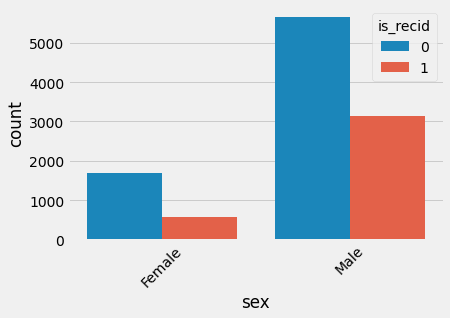

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.countplot(x=df_is_recid['sex'], hue='is_recid', data=df_is_recid)
plt.xticks(rotation=45)
plt.show()

Plotting charge degree

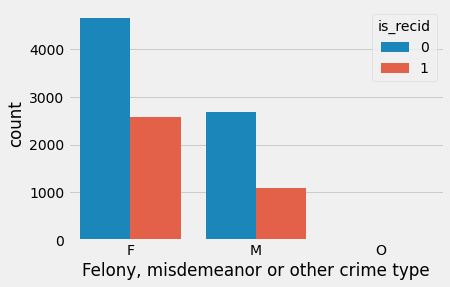

In [ ]:
df_is_recid = df[df['is_recid'] != -1]
sns.countplot(x=df_is_recid['c_charge_degree'], hue='is_recid', data=df_is_recid)
plt.xlabel("Felony, misdemeanor or other crime type")
plt.show()

All the columns analyzed above seem to be discriminant at least in part w.r.t. the class label. 

#### Graphical information - boxplots of numerical attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   days_b_screening_arrest  10577 non-null  float64
 1   c_days_from_compas       11015 non-null  float64
 2   v_decile_score           11757 non-null  int64  
 3   age                      11757 non-null  int64  
 4   juv_fel_count            11757 non-null  int64  
 5   decile_score             11757 non-null  int64  
 6   juv_misd_count           11757 non-null  int64  
 7   juv_other_count          11757 non-null  int64  
 8   priors_count             11757 non-null  int64  
 9   is_recid                 11757 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 918.6 KB


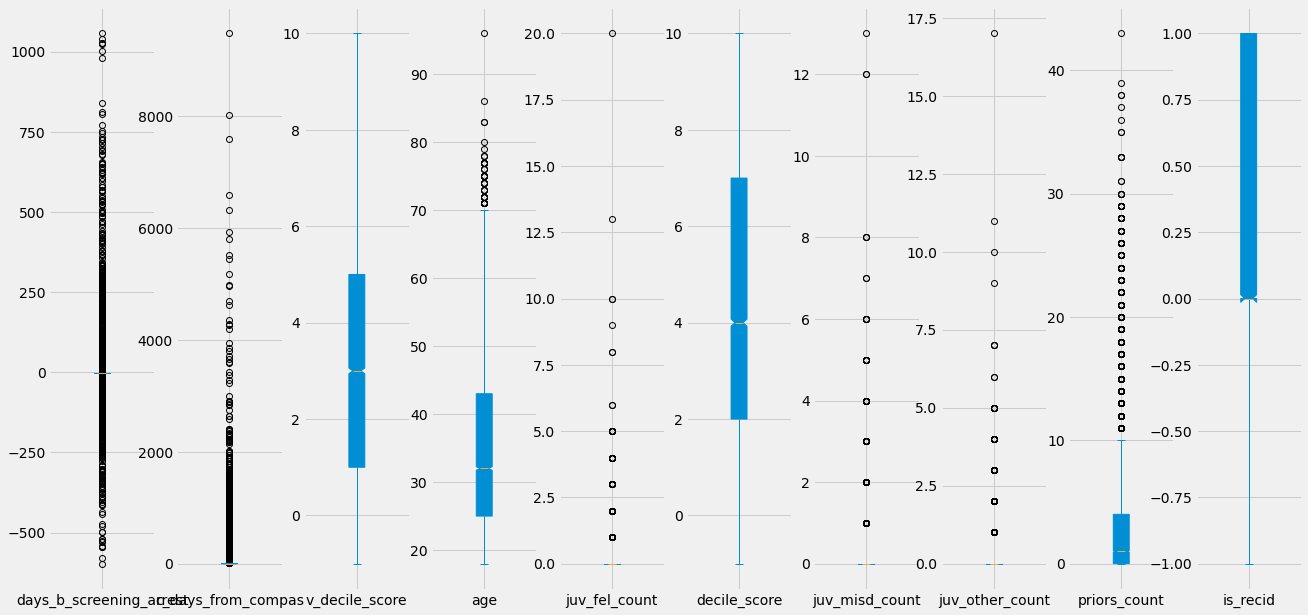

In [ ]:
numeric_cols_df.info()

numeric_cols_df.plot(kind='box', subplots=True, sharex=False, sharey=False, notch=True, patch_artist=True, figsize=(20,10))
plt.show()

#### Graphical information - scatterplots of numeric attributes

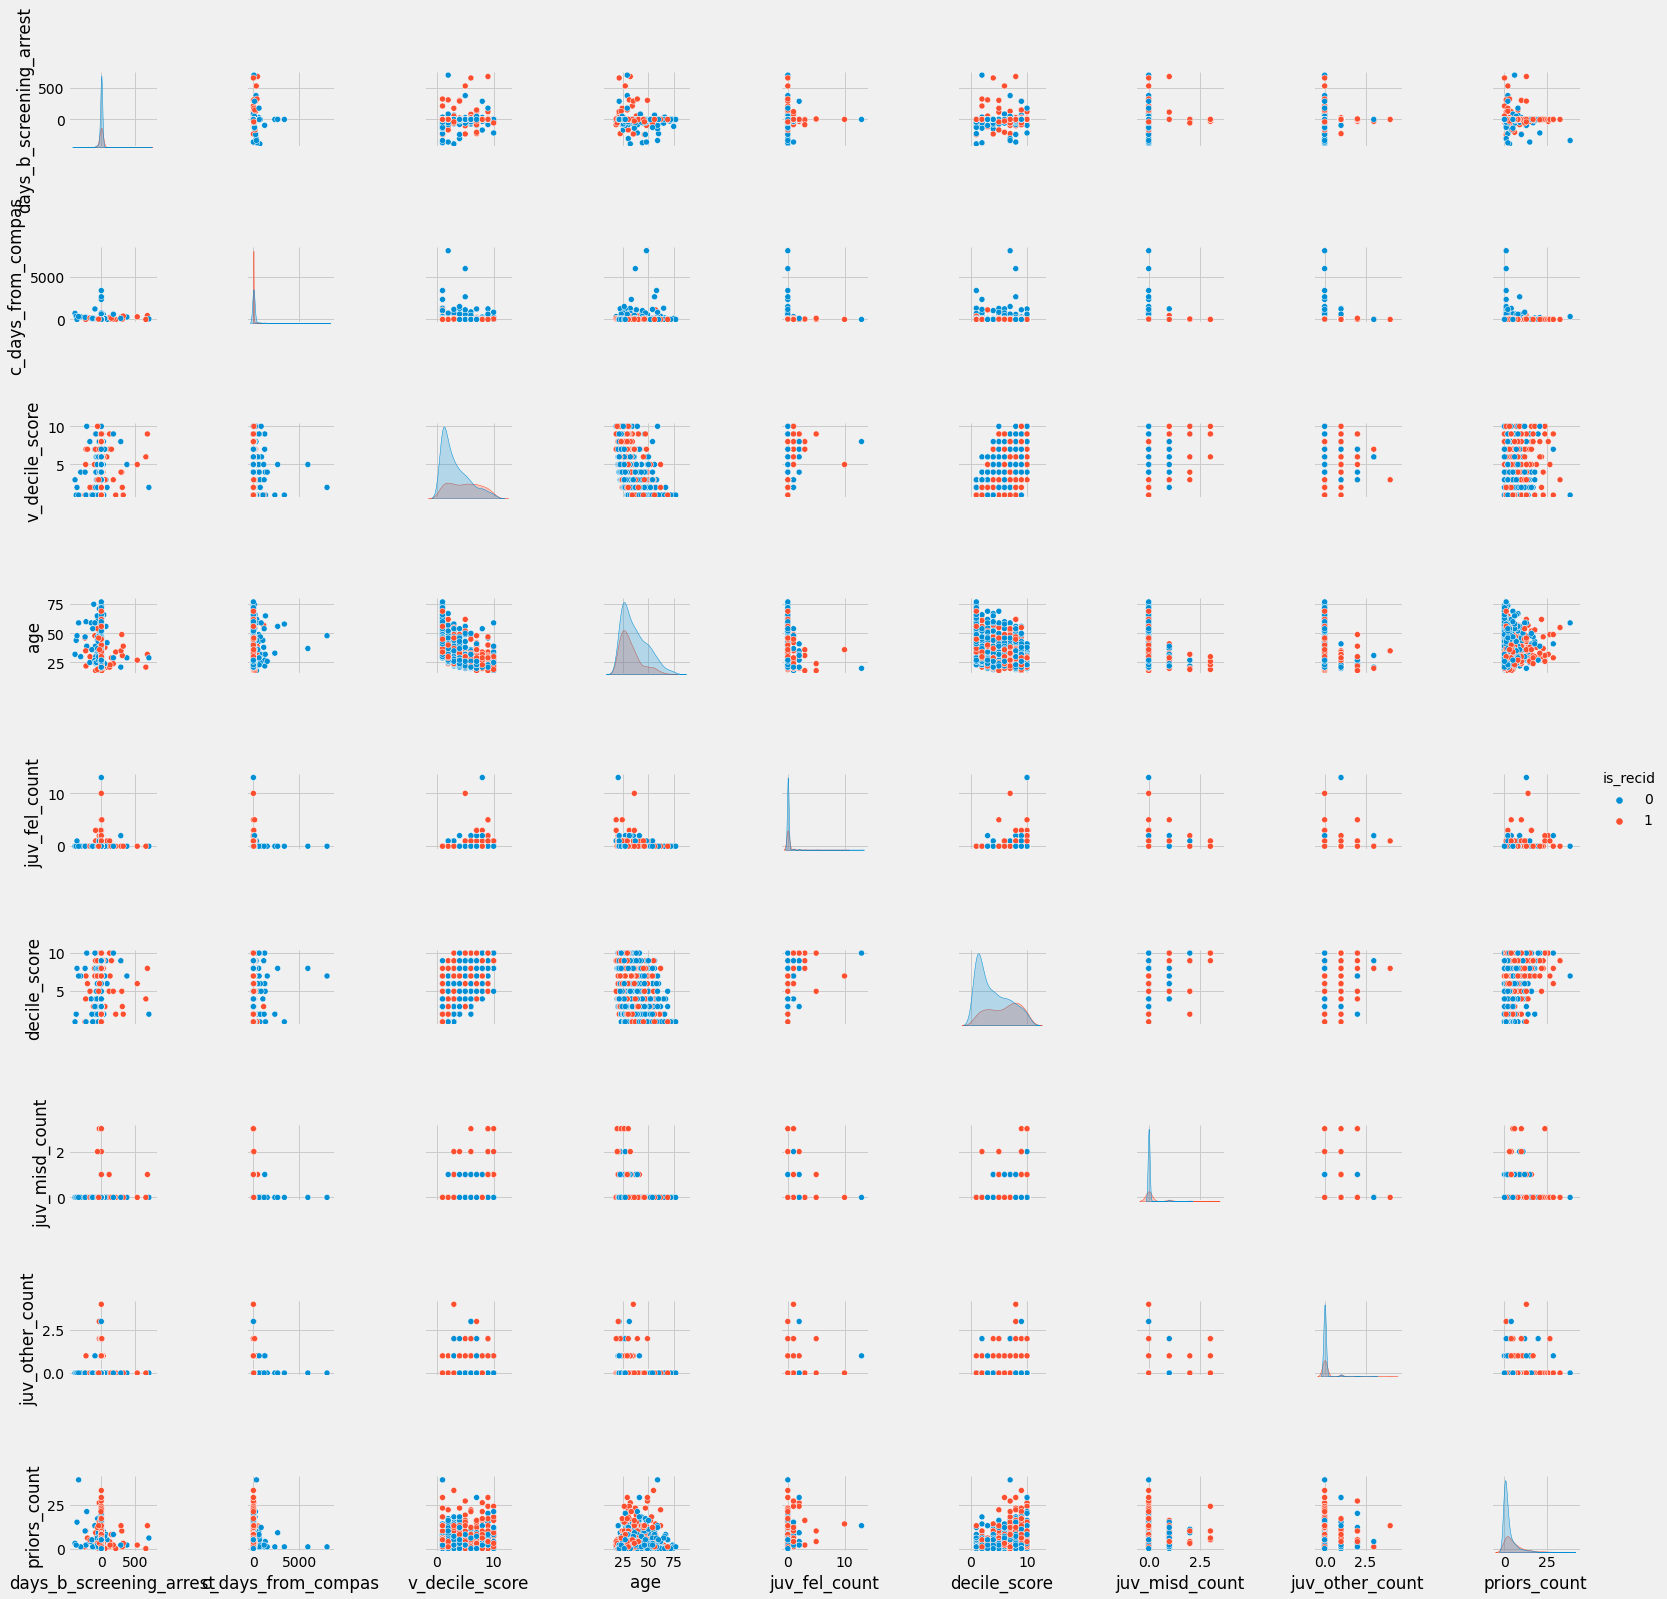

In [ ]:
# numeric_cols_df.info()
sns.pairplot((numeric_cols_df[numeric_cols_df['is_recid'] != -1]).sample(1000), hue="is_recid")
plt.show()

#### Graphical information - correlation matrix 

Correlation matrix between attributes

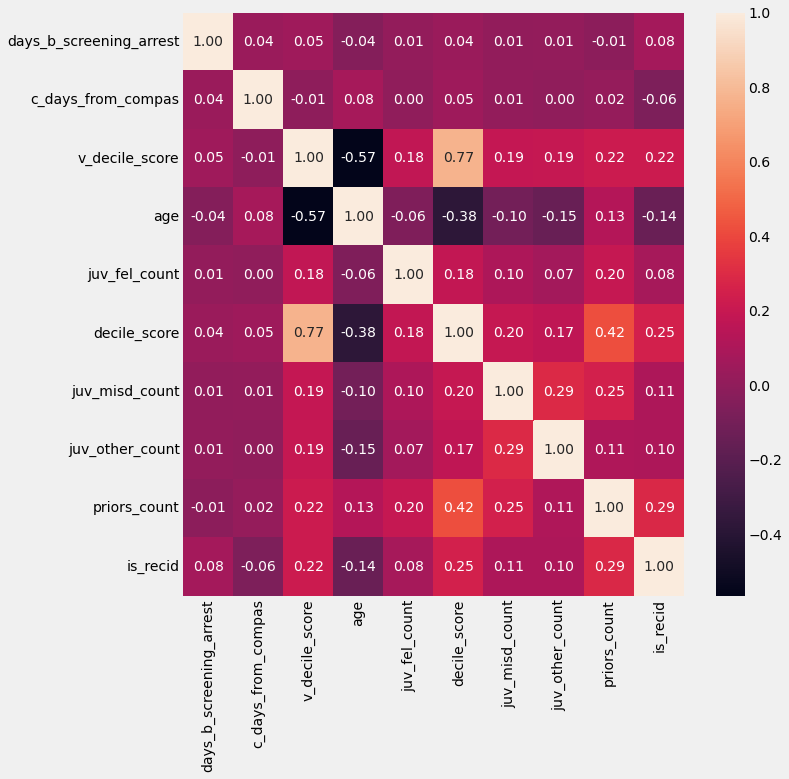

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(numeric_cols_df.corr(), annot=True, fmt='.2f')
plt.show()


### Data quality

#### Checking for inconsistencies

The *ProPublica* article suggested a discrepancy between the *name* column and *first* + *last* column. Let's check.

In [ ]:
full_names = pd.Series(df['first'], dtype="string")
first_names = pd.Series(df['first'], dtype="string")
last_names = pd.Series(df['last'], dtype="string")
error_count = 0
for i in range(len(full_names)):
  if full_names[i] != first_names[i] + " " + last_names[i]:
    error_count += 1

print(error_count)

11757


We could not prove the discrepancy suggested by the article.

Let's check how many cases there are with arrest dates or charge dates within **more** than 30 days of a COMPAS assessment being conducted.

In [ ]:
c_upper_bound = len(df[df['days_b_screening_arrest'] > 30])
c_lower_bound = len(df[df['days_b_screening_arrest'] < -30])

print("Count: {}".format(c_upper_bound + c_lower_bound))
print("Percentage: {}".format((c_upper_bound + c_lower_bound)/len(df)*100))

Count: 1181
Percentage: 10.045079527090243


Checking if the jail-in and jail-out dates are coherent (i.e., if jail-out > jail-in for each row)

In [ ]:
jail_out_dates = pd.to_datetime(df.c_jail_out)
jail_in_dates = pd.to_datetime(df.c_jail_in)

c = 0
for in_date, out_date in zip(jail_in_dates, jail_out_dates):
  if (in_date > out_date):
    c += 1

print("Count: {}".format(c))
print("Percentage: {}".format(c/len(df)*100))

Count: 302
Percentage: 2.5686824870290037


#### Duplicate columns

In [ ]:
df['compas_screening_date'].equals(df['screening_date'])

True

*compas_screening_date* is a duplicate of *screening_date*.

In [ ]:
df['decile_score'].equals(df['decile_score.1'])

True

*decile_score* is a duplicate of *decile_score.1*.

#### Null values

Calculating the percentage of null values

In [ ]:
n_of_points = len(df)
percentages = []
for attribute in df.columns:
  nan_value_sum = df[attribute].isna().sum()
  percentages.append(round((nan_value_sum/n_of_points)*100, 2)) 

# We will get rid of columns which have a >60% null value percentage
null_counts = pd.DataFrame({"columns": df.columns,
                            "percentage": percentages})
null_counts['percentage'].astype(float)
null_counts.sort_values(by=['percentage'], ascending=False).head(50)

,columns,percentage
34,num_vr_cases,100.000
25,num_r_cases,100.000
38,vr_charge_desc,92.500
37,vr_offense_date,92.500
36,vr_charge_degree,92.500
35,vr_case_number,92.500
20,c_arrest_date,84.200
31,r_jail_in,79.080
32,r_jail_out,79.080
28,r_days_from_arrest,79.080


Barplot of each column w.r.t. its null values percentage

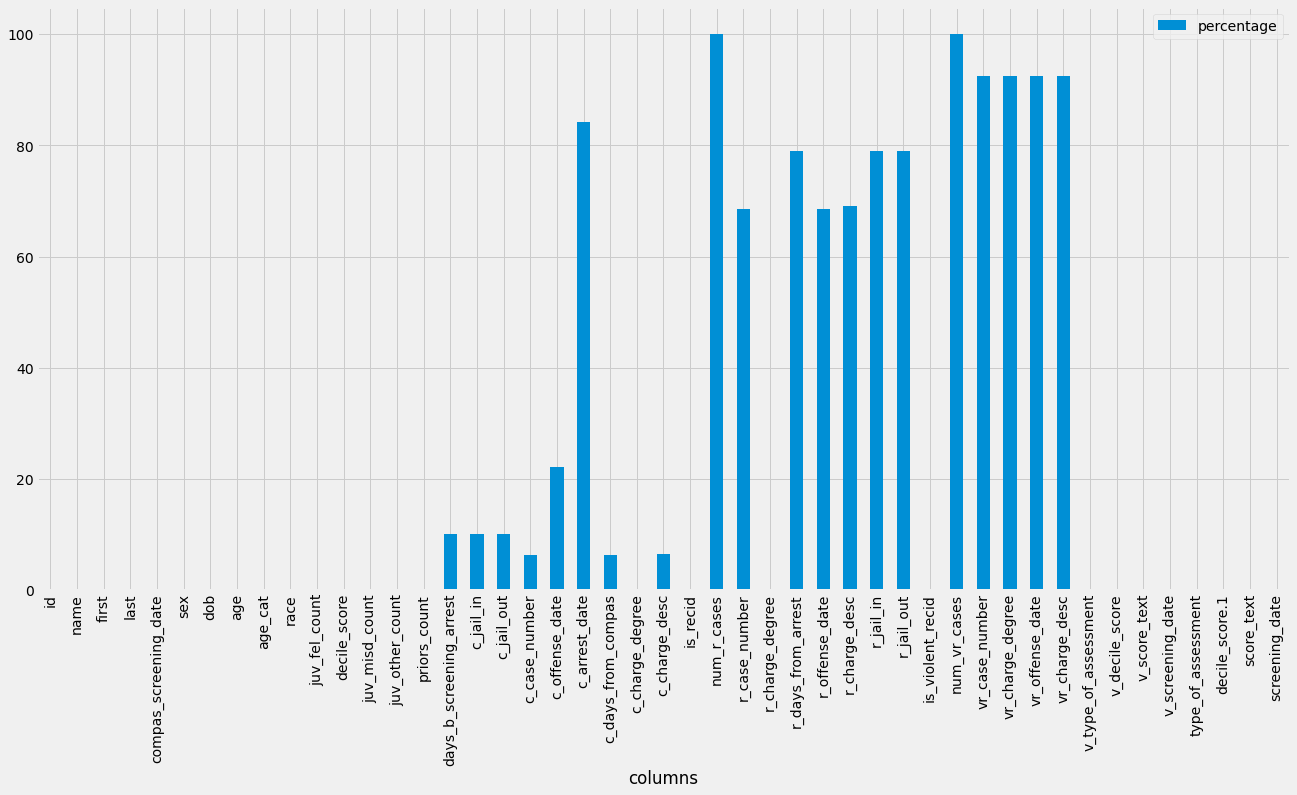

In [ ]:
_ = null_counts.plot(x="columns", y="percentage", kind="bar", figsize=(20,10))

Calculating null percentage of class label

In [ ]:
c_null_is_recid = len(df[df['is_recid'] == -1])
print("Count: {}".format(c_null_is_recid))
print("Percentage: {}".format((c_null_is_recid)/len(df)*100))

Count: 719
Percentage: 6.115505656204815


## Data preparation

### Problems

#### Dropping duplicate columns

In [ ]:
duplicates = ['decile_score.1', 'screening_date', 'v_screening_date']
df.drop(columns=duplicates, inplace = True)

#### Dropping columns with high null value percentage (> 60%)

In [ ]:
null_cols = ['num_vr_cases', 'num_r_cases', 'vr_charge_desc', 
          'vr_offense_date', 'vr_charge_degree',
          'vr_case_number', 'c_arrest_date',
          'r_jail_in', 'r_jail_out', 'r_days_from_arrest',
          'r_charge_desc', 'r_offense_date', 'r_case_number']
df.drop(columns=null_cols, inplace = True)

#### Dropping univariate columns

In [ ]:
univariate_cols = ['v_type_of_assessment', 'type_of_assessment']
df.drop(columns=univariate_cols, inplace = True)

#### Dropping excessively discriminant columns 

In [ ]:
for c in df.columns:
  if c.startswith('v_') or c.startswith('vr_') or c.startswith('r_'):
    df.drop(c, axis=1, inplace=True)

#### Dropping IDs

In [ ]:
id_cols = ['id', 'c_case_number']
df.drop(columns=id_cols, inplace = True)

#### Dropping useless columns

Dropping *is_violent_recid*, which is a class label outside of our scope. Dropping also categorical variables with too much levels

In [ ]:
df.drop(columns=['is_violent_recid', 'compas_screening_date', 'name', 'first', 'last', 
                 'c_offense_date', 'c_days_from_compas', 'score_text'], inplace=True)

#### Dropping redundancies

In [ ]:
redundancies = ['dob', 'age_cat']
df.drop(columns=redundancies, inplace = True)

#### Dropping dirty data

Removing rows where days before the screening arrest is <-30 and >30

In [ ]:
df.drop(df.loc[df['days_b_screening_arrest']<-30].index, inplace=True)
df.drop(df.loc[df['days_b_screening_arrest']>30].index, inplace=True)
df.drop(df.loc[df['is_recid'] == -1].index, inplace=True)

Removing rows with at least one null value

In [ ]:
df.dropna(inplace=True)

### Transformations

#### New column creation

Deleting the columns containing the jail_in and jail_out dates and creating a new one containing the amount of days in jail.

In [ ]:
days_in_prison = pd.Series(index=df.index, dtype='int')

for ind in df.index:
    jail_out_date = pd.to_datetime(df['c_jail_out'][ind])
    jail_in_date = pd.to_datetime(df['c_jail_in'][ind])

    if(jail_out_date < jail_in_date):
      df.drop(ind, inplace=True)
    else:
      days_in_prison[ind] = (jail_out_date - jail_in_date).days

df['days_in_prison'] = days_in_prison

# Now these columns are redundant, thus we drop them
df.drop('c_jail_in', axis=1, inplace=True)
df.drop('c_jail_out', axis=1, inplace=True)

#### Unifying column values

The *charge_desc* column contains way too many values for it to be useful in modeling. Thus, we categorize crimes in 7 macro-buckets.

In [ ]:
charge_desc_col = df['c_charge_desc'].astype(str)

for ind in charge_desc_col.index:
  if(type(charge_desc_col[ind]) is str):
    x = charge_desc_col[ind].lower()
    if('assault' in x):
      charge_desc_col[ind] = 'Assault'
    elif ('robbery' in x):
      charge_desc_col[ind] = 'Robbery'
    elif ('poss' in x):
      charge_desc_col[ind] = 'Possession of drugs'
    elif ('battery' in x):
      charge_desc_col[ind] = 'Battery'
    elif ( 'burgl' in x or 'theft' in x ):
      charge_desc_col[ind] = 'Burglary'
    elif ( 'del' in x):
      charge_desc_col[ind] = 'Drug delivery'
    elif( 'dui' in x or 'driv' in x):
      charge_desc_col[ind] = 'DUI'
    else:
      charge_desc_col[ind] = 'Other'

df['c_charge_desc'] = charge_desc_col

#### Binarization of columns

Binarizing columns where the distributions are very strongly skewed towards one single value. 

In [ ]:
df['priors_count'] = df['priors_count'].apply(lambda x: 'less than 10' if (x < 10) else '10 or more')
df['juv_misd_count'] = df['juv_misd_count'].apply(lambda x: '0' if (x == 0) else '> 0')
df['juv_other_count'] = df['juv_other_count'].apply(lambda x: '0' if (x == 0) else '> 0')
df['juv_fel_count'] = df['juv_fel_count'].apply(lambda x: '0' if (x == 0) else '> 0')

Checking final form of the dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9123 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   sex                      9123 non-null   category
 1   age                      9123 non-null   int64   
 2   race                     9123 non-null   category
 3   juv_fel_count            9123 non-null   object  
 4   decile_score             9123 non-null   int64   
 5   juv_misd_count           9123 non-null   object  
 6   juv_other_count          9123 non-null   object  
 7   priors_count             9123 non-null   object  
 8   days_b_screening_arrest  9123 non-null   float64 
 9   c_charge_degree          9123 non-null   category
 10  c_charge_desc            9123 non-null   object  
 11  is_recid                 9123 non-null   int64   
 12  days_in_prison           9123 non-null   int64   
dtypes: category(3), float64(1), int64(4), object(5)
memory usage: 

## Modeling 

### Preprocessing

Encoding categories as numbers

In [ ]:
number = preprocessing.LabelEncoder()
for attribute in df.columns:
  if df[attribute].dtype == object:
    df[attribute] = df[attribute].astype('category')
  if df[attribute].dtype == 'category':
    df[attribute] = number.fit_transform(df[attribute])

### Resampling

Class labels are not balanced, as we can see from the cell below.

In [ ]:
df.is_recid.value_counts()

0    6005
1    3118
Name: is_recid, dtype: int64

#### Oversampling

Let's try an oversampling strategy called SMOTE.

In [ ]:
X = df.drop('is_recid', axis=1)
y = df['is_recid']

seed = 131
split = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)

Let's use the SMOTE oversampling strategy and check class balance. As we can see from the cell below they are exactly balanced now.

In [ ]:
X_train_over, y_train_over = SMOTE().fit_resample(X_train, y_train)
training_set_over = pd.concat([X_train_over, y_train_over], axis=1)
training_set_over.is_recid.value_counts()

0    4782
1    4782
Name: is_recid, dtype: int64

#### Undersampling

Let's create an undersampled version of the dataset.

In [ ]:
temp_set = pd.concat([X_train, y_train], axis=1)
recidives = temp_set[temp_set.is_recid == 1]
non_recidives = temp_set[temp_set.is_recid == 0]

non_recidives_resampled = resample(non_recidives, 
                       replace=True, 
                       n_samples=int(len(recidives) * 1.1),
                       random_state=seed)

training_set_under = pd.concat([recidives, non_recidives_resampled])
X_train_under = training_set_under.drop('is_recid', axis=1)
y_train_under = training_set_under['is_recid']

Checking balance.

In [ ]:
training_set_under.is_recid.value_counts()

0    2767
1    2516
Name: is_recid, dtype: int64

### Grid search 

#### Searching for best parameters: Random Forest

In [ ]:
param_grid_rf = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10],
              'criterion': ['gini', 'entropy'],
              'max_leaf_nodes': [5, 10, 15]}

rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_rf,
    cv=5,
    verbose=1,
    scoring='f1'
)

# Getting best parameters for oversampled set
rf_grid_search.fit(X_train_over, y_train_over)
best_params_rf_over = rf_grid_search.best_params_

# Getting best parameters for undersampled set
rf_grid_search.fit(X_train_under, y_train_under)
best_params_rf_under = rf_grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


#### Searching for best parameters: Naive Bayes

In [ ]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

nb_grid_search = GridSearchCV(estimator=GaussianNB(), 
                 param_grid=param_grid_nb, 
                 cv=5,    
                 verbose=1, 
                 scoring='f1') 

# Getting best parameters for oversampled set
nb_grid_search.fit(X_train_over, y_train_over)
best_params_nb_over = nb_grid_search.best_params_

# Getting best parameters for undersampled set
nb_grid_search.fit(X_train_under, y_train_under)
best_params_nb_under = nb_grid_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


#### Searching for best parameters: AdaBoost

In [ ]:
param_grid_ab = {'base_estimator__max_depth':[5, 10],
              'base_estimator__min_samples_leaf':[2, 5],
              'base_estimator__criterion': ['gini', 'entropy'],
              'base_estimator__max_leaf_nodes': [5, 10], 
              'n_estimators':[10, 20, 50],
              'learning_rate':[0.01, 0.1]}

ab_grid_search = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), 
                              param_grid=param_grid_ab, 
                              cv=5,
                              verbose=1, 
                              scoring='f1')

# Getting best parameters for oversampled set
ab_grid_search.fit(X_train_over, y_train_over)
best_params_ab_over = ab_grid_search.best_params_

# Getting best parameters for undersampled set
ab_grid_search.fit(X_train_under, y_train_under)
best_params_ab_under = ab_grid_search.best_params_


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits


### Fitting

Below are the best parameters found from grid search.

In [ ]:
print(best_params_rf_over)
print(best_params_rf_under)
print(best_params_nb_over)
print(best_params_nb_under)
print(best_params_ab_over)
print(best_params_ab_under)

{'criterion': 'gini', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_split': 10}
{'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_split': 10}
{'var_smoothing': 0.0004328761281083057}
{'var_smoothing': 0.0008111308307896872}
{'base_estimator__criterion': 'entropy', 'base_estimator__max_depth': 5, 'base_estimator__max_leaf_nodes': 5, 'base_estimator__min_samples_leaf': 2, 'learning_rate': 0.1, 'n_estimators': 10}
{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'base_estimator__max_leaf_nodes': 5, 'base_estimator__min_samples_leaf': 2, 'learning_rate': 0.01, 'n_estimators': 50}


#### Creating models

Creating models with the best parameters found by grid search.

In [ ]:
models_over = []
models_over.append(("Random Forest", RandomForestClassifier(criterion='entropy', 
                                                       max_depth=3,
                                                       max_leaf_nodes=10,
                                                       min_samples_split=2)))

models_over.append(("Naive Bayes", GaussianNB(var_smoothing=0.0008111308307896872)))
models_over.append(("DT AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',
                                                                             max_depth=5, 
                                                                             max_leaf_nodes=10,
                                                                             min_samples_leaf=2),
                                                      learning_rate=0.1,
                                                      n_estimators=50)))

models_under = []
models_under.append(("Random Forest", RandomForestClassifier(criterion='entropy', 
                                                       max_depth=10,
                                                       max_leaf_nodes=5,
                                                       min_samples_split=2)))
models_under.append(("Naive Bayes", GaussianNB(var_smoothing=0.0008111308307896872)))
models_under.append(("DT AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(criterion='gini',
                                                                             max_depth=5, 
                                                                             max_leaf_nodes=5,
                                                                             min_samples_leaf=2),
                                                      learning_rate=0.01,
                                                      n_estimators=50)))

metrics = ['accuracy', 'recall', 'precision', 'f1']

#### Fitting models on oversampling data

Now fitting the models on oversampling data.

In [ ]:
for name, model in models_over:
    kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
    cv_results = cross_validate(model, X_train_over, y_train_over, cv=kfold, scoring=metrics)
    print(f'Model: {model}')
    for key in cv_results.keys():
      if 'test' in key:
        mean_metric = np.array(cv_results[key]).mean()
        std_metric = np.array(cv_results[key]).std()
        print(f'{key} - mean: {round(mean_metric, 2)}, std: {round(std_metric, 2)}')
    print('')

Model: RandomForestClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=10)
test_accuracy - mean: 0.65, std: 0.02
test_recall - mean: 0.68, std: 0.02
test_precision - mean: 0.64, std: 0.02
test_f1 - mean: 0.66, std: 0.02

Model: GaussianNB(var_smoothing=0.0008111308307896872)
test_accuracy - mean: 0.62, std: 0.01
test_recall - mean: 0.74, std: 0.02
test_precision - mean: 0.59, std: 0.02
test_f1 - mean: 0.66, std: 0.01

Model: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=5,
                                                         max_leaf_nodes=10,
                                                         min_samples_leaf=2),
                   learning_rate=0.1)
test_accuracy - mean: 0.69, std: 0.02
test_recall - mean: 0.66, std: 0.01
test_precision - mean: 0.71, std: 0.02
test_f1 - mean: 0.68, std: 0.01



#### Fitting models on undersampling data

Now fitting the models on undersampling data.

In [ ]:
print('Fitting')
for name, model in models_under:
    kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
    cv_results = cross_validate(model, X_train_under, y_train_under, cv=kfold, scoring=metrics)
    print(f'Model: {model}')
    for key in cv_results.keys():
      if 'test' in key:
        mean_metric = np.array(cv_results[key]).mean()
        std_metric = np.array(cv_results[key]).std()
        print(f'{key} - mean: {round(mean_metric, 2)}, std: {round(std_metric, 2)}')
    print('')

Fitting
Model: RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=5)
test_accuracy - mean: 0.65, std: 0.02
test_recall - mean: 0.65, std: 0.02
test_precision - mean: 0.63, std: 0.03
test_f1 - mean: 0.64, std: 0.02

Model: GaussianNB(var_smoothing=0.0008111308307896872)
test_accuracy - mean: 0.62, std: 0.02
test_recall - mean: 0.71, std: 0.03
test_precision - mean: 0.58, std: 0.03
test_f1 - mean: 0.64, std: 0.02

Model: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         max_leaf_nodes=5,
                                                         min_samples_leaf=2),
                   learning_rate=0.01)
test_accuracy - mean: 0.64, std: 0.02
test_recall - mean: 0.69, std: 0.04
test_precision - mean: 0.61, std: 0.03
test_f1 - mean: 0.65, std: 0.03



## Evaluation 

### Choosing the best models

We keep the two best models according to metrics.

In [ ]:
rf_final_model = models_over[0][1]
rf_final_model.fit(X_train_over, y_train_over)
rf_predictions_final = rf_final_model.predict(X_test)

ab_final_model = models_over[2][1]
ab_final_model.fit(X_train_over, y_train_over)
ab_predictions_final = ab_final_model.predict(X_test)

### Comparing the best models chosen

#### Plotting confusion matrix

Creating the function

In [ ]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    sns.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, 
                xticklabels=categories, yticklabels=categories)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

Plotting for AdaBoost

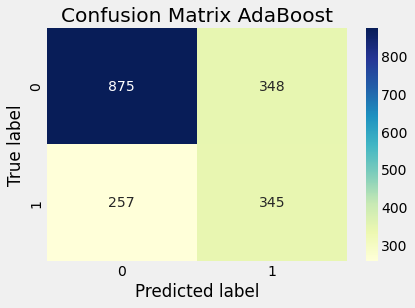

In [ ]:
categories = ['0', '1']

make_confusion_matrix(confusion_matrix(y_test, ab_predictions_final), 
                      categories=categories, cmap='YlGnBu', 
                      title='Confusion Matrix AdaBoost')

Plotting for Random Forest

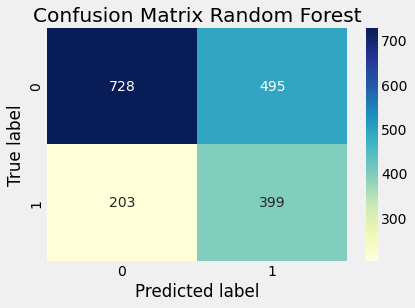

In [ ]:
make_confusion_matrix(confusion_matrix(y_test, rf_predictions_final), 
                      categories=categories, cmap='YlGnBu', 
                      title='Confusion Matrix Random Forest')

#### Summary of metrics

Summary for Random Forest

In [ ]:
print(classification_report(y_test, rf_predictions_final))

              precision    recall  f1-score   support

           0       0.78      0.60      0.68      1223
           1       0.45      0.66      0.53       602

    accuracy                           0.62      1825
   macro avg       0.61      0.63      0.60      1825
weighted avg       0.67      0.62      0.63      1825



Summary for AdaBoost

In [ ]:
print(classification_report(y_test, ab_predictions_final))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1223
           1       0.50      0.57      0.53       602

    accuracy                           0.67      1825
   macro avg       0.64      0.64      0.64      1825
weighted avg       0.68      0.67      0.67      1825



#### Plotting the ROC curve

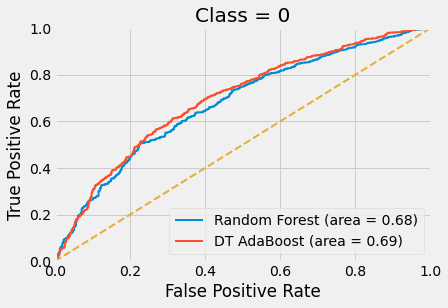

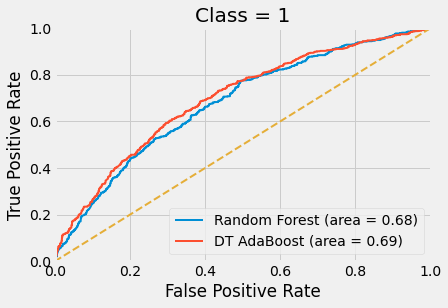

In [ ]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['is_recid']))
probs = []
del models_over[1]

for _, model in models_over:
    probs.append(model.predict_proba(X_test))
    
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0

    for name, _ in models_over:
        fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, label=name + f' (area = {roc_auc[i]:.2f})')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y)[i]))
    plt.legend(loc='lower right')

    plt.show()